In [1]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import seaborn as sns
from matplotlib import pyplot as plt
pd.set_option('display.max_columns', 100)

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

from tqdm.auto import tqdm
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [2]:
df = pd.read_csv('cian_preprocessed_no_extreme.csv', low_memory=False, index_col='cid')
print(df.shape)
df.head(3)

(56105, 31)


,location_sub_locality_name,location_latitude,location_longitude,sales_agent_category,price_value,area_value,living_space_value,kitchen_space_value,description,rooms,floor,floors_total,price_agent_fee,studio,metro_1,metro_2,metro_3,metro_1_foot,metro_2_foot,metro_3_foot,metro_1_transport,metro_2_transport,metro_3_transport,metro_foot_max,metro_foot_min,metro_transport_max,metro_transport_min,floors_total_adjust,living_space_share,kitchen_space_share,price_per_sqm
cid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10712873,ЦАО,55.769707,37.591117,agency,100000.0,45.0,27.0,8.0,"ID 105 Сдается от 1 мес!Отчетные документы, ре...",0,4.0,5.0,0,0,Маяковская,Белорусская,Тверская,6.0,10.0,13.0,-1.0,-1.0,-1.0,13.0,6.0,-1.0,999.0,5.0,0.600000,0.177778,2222.222222
12833884,ЦАО,55.739554,37.597414,agency,500000.0,150.0,100.0,50.0,Агенту Бонус 50/50 ЖК Опера Хаус. В аренду пр...,0,2.0,7.0,0,0,Кропоткинская,Парк Культуры,none,7.0,7.0,-1.0,-1.0,-1.0,-1.0,7.0,7.0,-1.0,999.0,9.0,0.666667,0.333333,3333.333333
145766778,ЦАО,55.722162,37.613090,agency,140000.0,114.0,64.0,20.0,"ЖК Созвездие капитал-1, Предлагается в аренду ...",0,3.0,20.0,0,0,Шаболовская,none,none,8.0,-1.0,-1.0,-1.0,-1.0,-1.0,8.0,8.0,-1.0,999.0,24.0,0.561404,0.175439,1228.070175


In [3]:
df.drop(['price_value', 'area_value'], axis=1, inplace=True)

In [4]:
# df = pd.get_dummies(
#     df, 
#     columns=['location_sub_locality_name', 'sales_agent_category', 'metro_1', 'metro_2', 'metro_3'],
#     prefix=['locname', 'agent', 'm1', 'm2', 'm3']
# )
# df.head(3)

In [5]:
df = pd.get_dummies(
    df, 
    columns=['location_sub_locality_name', 'sales_agent_category'],
    prefix=['locname', 'agent'],
    drop_first=True
)

metros = np.unique(df[['metro_1', 'metro_2', 'metro_3']].values.ravel())
le = LabelEncoder()
le.fit(metros)
for col in ['metro_1', 'metro_2', 'metro_3']: 
    df[col] = le.transform(df[col])
df.head(3)

,location_latitude,location_longitude,living_space_value,kitchen_space_value,description,rooms,floor,floors_total,price_agent_fee,studio,metro_1,metro_2,metro_3,metro_1_foot,metro_2_foot,metro_3_foot,metro_1_transport,metro_2_transport,metro_3_transport,metro_foot_max,metro_foot_min,metro_transport_max,metro_transport_min,floors_total_adjust,living_space_share,kitchen_space_share,price_per_sqm,locname_ЗАО,locname_НАО (Новомосковский),locname_САО,locname_СВАО,locname_СЗАО,locname_ЦАО,locname_ЮАО,locname_ЮВАО,locname_ЮЗАО,agent_owner
cid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10712873,55.769707,37.591117,27.0,8.0,"ID 105 Сдается от 1 мес!Отчетные документы, ре...",0,4.0,5.0,0,0,423,20,236,6.0,10.0,13.0,-1.0,-1.0,-1.0,13.0,6.0,-1.0,999.0,5.0,0.600000,0.177778,2222.222222,0,0,0,0,0,1,0,0,0,0
12833884,55.739554,37.597414,100.0,50.0,Агенту Бонус 50/50 ЖК Опера Хаус. В аренду пр...,0,2.0,7.0,0,0,397,171,297,7.0,7.0,-1.0,-1.0,-1.0,-1.0,7.0,7.0,-1.0,999.0,9.0,0.666667,0.333333,3333.333333,0,0,0,0,0,1,0,0,0,0
145766778,55.722162,37.613090,64.0,20.0,"ЖК Созвездие капитал-1, Предлагается в аренду ...",0,3.0,20.0,0,0,573,297,297,8.0,-1.0,-1.0,-1.0,-1.0,-1.0,8.0,8.0,-1.0,999.0,24.0,0.561404,0.175439,1228.070175,0,0,0,0,0,1,0,0,0,0


In [6]:
bool_cols = []
for col in tqdm(df.columns):
    if df[col].nunique() == 2:
        bool_cols.append(col) 

  0%|          | 0/37 [00:00<?, ?it/s]

In [7]:
target = 'price_per_sqm'
text_cols = ['description']
num_cols = [i for i in df.columns if i not in bool_cols + text_cols + [target]]
feature_cols = text_cols + bool_cols + num_cols

In [8]:
x_train_full, x_test, y_train_full, y_test = train_test_split(
    df[feature_cols], 
    df[target], 
    test_size=0.15, 
    random_state=17
)

In [9]:
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_full, 
    y_train_full, 
    test_size=0.15, 
    random_state=17
)

In [10]:
x_train_full.shape, x_train.shape, x_valid.shape, x_test.shape, \
y_train_full.shape, y_train.shape, y_valid.shape, y_test.shape

((47689, 36),
 (40535, 36),
 (7154, 36),
 (8416, 36),
 (47689,),
 (40535,),
 (7154,),
 (8416,))

In [11]:
cbs = CatBoostRegressor()

In [12]:
cbs.fit(
    x_train.drop(text_cols, axis=1), 
    y_train, 
    eval_set=(x_valid.drop(text_cols, axis=1), y_valid),
    verbose=50,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.091059
0:	learn: 615.1586698	test: 631.0858150	best: 631.0858150 (0)	total: 55.5ms	remaining: 55.5s
50:	learn: 377.3169965	test: 388.5984303	best: 388.5984303 (50)	total: 209ms	remaining: 3.88s
100:	learn: 356.6401435	test: 371.8858967	best: 371.8858967 (100)	total: 348ms	remaining: 3.1s
150:	learn: 340.5946493	test: 359.2818918	best: 359.2818918 (150)	total: 487ms	remaining: 2.74s
200:	learn: 330.3707793	test: 352.3890986	best: 352.3890986 (200)	total: 625ms	remaining: 2.48s
250:	learn: 321.3844865	test: 346.4411133	best: 346.4411133 (250)	total: 769ms	remaining: 2.29s
300:	learn: 312.6252564	test: 340.4902340	best: 340.4902340 (300)	total: 909ms	remaining: 2.11s
350:	learn: 305.9484870	test: 336.6849665	best: 336.6849665 (350)	total: 1.07s	remaining: 1.97s
400:	learn: 299.6661986	test: 332.9555254	best: 332.9555254 (400)	total: 1.22s	remaining: 1.82s
450:	learn: 294.5912698	test: 330.2419687	best: 330.2419687 (450)	total: 1.36s	remaining: 1.65s
500:	learn: 289.

In [13]:
y_test_pred = cbs.predict(x_test.drop(text_cols, axis=1))

In [14]:
mse_test = mean_squared_error(y_test_pred, y_test, squared=False)
mse_val = mean_squared_error(cbs.get_test_eval(), y_valid, squared=False)
mape_test = mean_absolute_percentage_error(y_test_pred, y_test)
mape_val = mean_absolute_percentage_error(cbs.get_test_eval(), y_valid)
r2_val = cbs.score(x_valid.drop(text_cols, axis=1), y_valid)
r2_test = cbs.score(x_test.drop(text_cols, axis=1), y_test)

In [15]:
print(f"""mse_test: {mse_test:.4f}
mse_val: {mse_val:.4f}
mape_test: {mape_test*100:.2f}%
mape_val: {mape_val*100:.2f}%
r2_test: {r2_test:.4f}
r2_val: {r2_val:.4f}""")

mse_test: 307.1151
mse_val: 312.9978
mape_test: 14.28%
mape_val: 14.29%
r2_test: 0.7520
r2_val: 0.7759


In [16]:
cbs.score(x_valid.drop(text_cols, axis=1), y_valid)

0.7759325822632588

In [17]:
cbs.score(x_test.drop(text_cols, axis=1), y_test)

0.7520478418059368

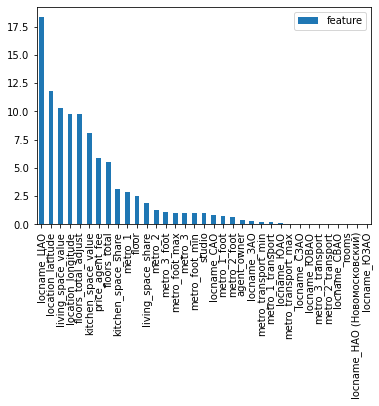

In [18]:
imp = pd.DataFrame(cbs.feature_importances_, cbs.feature_names_, columns=['feature']
                  ).sort_values('feature', ascending=False)
imp.plot(kind='bar');

In [19]:
pd.DataFrame(cbs.feature_importances_, cbs.feature_names_).sort_values(0, ascending=False).head(30)

,0
locname_ЦАО,18.324810
location_latitude,11.821203
living_space_value,10.312670
location_longitude,9.788609
floors_total_adjust,9.762753
kitchen_space_value,8.132629
price_agent_fee,5.886307
floors_total,5.484520
kitchen_space_share,3.116233
metro_1,2.875237


In [20]:
tmp = pd.DataFrame(y_valid)
tmp['pred'] = cbs.get_test_eval()
tmp['mape'] = np.abs(1 - tmp['price_per_sqm'] / tmp['pred'])

<AxesSubplot:xlabel='price_per_sqm', ylabel='mape'>

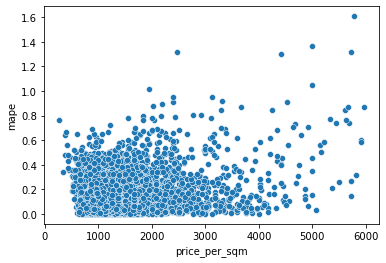

In [21]:
sns.scatterplot(data=tmp, x='price_per_sqm', y='mape')

<AxesSubplot:>

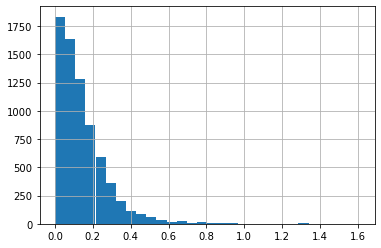

In [22]:
tmp.mape.hist(bins=30)